In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

from generate_input import generate_input
from models import GameOfLifeModel, ContinuousGameOfLife3x3
from costumised_layers import CyclicPadding2D
from tools import create_masks

Visualizing the continuous model for the 3x3 game of life.  It uses two variables:
- the state of the cell
- the sum of the states of the neighbouring cells

and it does exactly what is shown in the figure below

In [2]:
around_cell_possible_values = np.arange(8, -0.00001, -0.02)
cell_possible_values = np.arange(0,1.00001,0.01)

around_cell = [list(around_cell_possible_values)]*len(cell_possible_values)
cell = [list(cell_possible_values)] * len(around_cell_possible_values)

around_cell = np.array(around_cell)
around_cell = np.transpose(around_cell)
cell = np.array(cell)

In [5]:
around_cell = tf.constant(around_cell)
cell = tf.constant(cell)

almost_zero = 0.01
border = 0.4

x1 = tf.math.maximum(((8-around_cell)/(8-3))*almost_zero, (3+border-around_cell)/border )
x2 = tf.math.maximum((around_cell-(3-border))/border, around_cell*almost_zero/3 )

x3 = tf.math.maximum((cell-(1-border))/border, cell*almost_zero)

x4 = tf.math.maximum((around_cell-(2-border))/border, around_cell*almost_zero/2 )

x12 = tf.math.minimum(x1,x2)
x34 = tf.math.minimum(x3,x4)

x5 = tf.math.minimum(x1,x34)
xx = tf.math.maximum(x12,x5)



The colour indicates the status of the cell for the next step


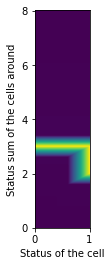

In [6]:
plt.figure(figsize=(2,4))
plt.imshow(xx, vmin=0, vmax=1)

plt.yticks([401,301, 201, 101, 0], [0,2,4,6, 8])
plt.xticks([0,101], [0,1])
plt.xlabel('Status of the cell')
plt.ylabel('Status sum of the cells around')

print('The colour indicates the status of the cell for the next step')

In [33]:
k1 = tf.constant([[1,1,1],[1,0,1],[1,1,1]], dtype='float32')
k1 = tf.reshape(k1, shape=(3,3,1,1))
k2 = tf.constant([[0,0,0],[0,1,0],[0,0,0]], dtype='float32')
k2 = tf.reshape(k2, shape=(3,3,1,1))

def compute_loss(input_img, target):
    input_img[:,0,:].assign(input_img[:,-2,:])
    input_img[:,-1,:].assign(input_img[:,1,:])
    input_img[:,:,0].assign(input_img[:,:,-2])
    input_img[:,:,-1].assign(input_img[:,:,1])

    input_img = tf.reshape(input_img, shape=(1, l+2, l+2, 1))
    cell = tf.nn.conv2d(input_img, filters=k2, strides=1, padding='VALID')
    around_cell = tf.nn.conv2d(input_img, filters=k1, strides=1, padding='VALID')

    almost_zero = 0.01
    border = 0.8

    x1 = tf.math.maximum(((8-around_cell)/(8-3))*almost_zero, (3+border-around_cell)/border )
    x2 = tf.math.maximum((around_cell-(3-border))/border, around_cell*almost_zero/3 )

    x3 = tf.math.maximum((cell-(1-border))/border, cell*almost_zero)

    x4 = tf.math.maximum((around_cell-(2-border))/border, around_cell*almost_zero/2 )

    x12 = tf.math.minimum(x1,x2)
    x34 = tf.math.minimum(x3,x4)

    x5 = tf.math.minimum(x1,x34)
    xx = tf.math.maximum(x12,x5)

    xx = tf.reshape(xx, shape=(l,l))
    y = tf.math.abs(xx-target)
    
    loss = tf.reduce_mean(y)

    loss1 =tf.reduce_mean(tf.math.abs(xx - xx**2))
    return loss 

@tf.function
def gradient_ascent_step(img, target, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, target)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    mask = tf.keras.backend.random_binomial(shape=(6,6), p=1)
    grads = tf.multiply(grads, mask)
    # Normalize gradients.
    grads_normed = tf.math.l2_normalize(grads*learning_rate)
    img.assign_sub(grads_normed)
    return loss, img, grads_normed

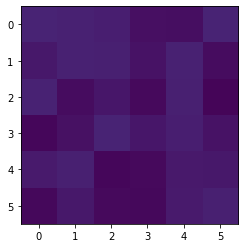

In [34]:
l = 4

img = tf.Variable(tf.random.uniform(shape=(1,l+2,l+2), minval=0.01, maxval=0.1), trainable=True, validate_shape=True)

# grid = tf.Variable(CyclicPadding2D()(y[1:2]))

# img = img + tf.Variable(tf.random.uniform(shape=(1,l+2,l+2), minval=-0.1, maxval=0.1), trainable=True, validate_shape=True)

plt.imshow(img[0], vmin=0, vmax=1)

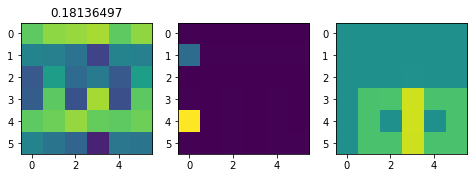

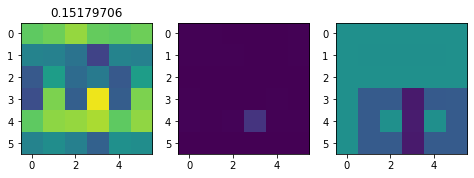

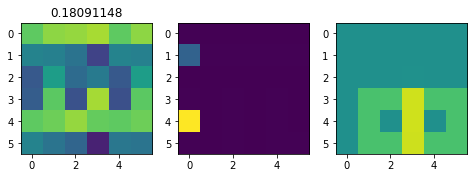

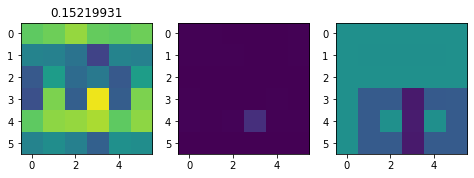

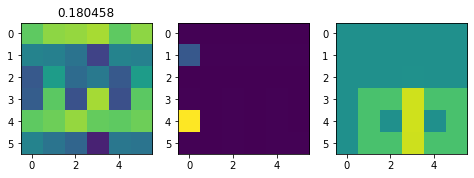

In [40]:
iterations = 4
for _ in range(5):
    for i in range(1):
        # for m in [M1, M2, M3, M4]:
        loss, img , gr = gradient_ascent_step(img, y[1], 0.1)
        img = tf.Variable(img)
            
    img = tf.Variable(img)
    plt.figure(figsize=(8, 3*4))
    plt.subplot(4,3, 1)
    plt.title(str(loss.numpy()))
    plt.imshow(img[0], vmin=-2, vmax=2)
    plt.subplot(4, 3, 2)
    plt.imshow( game(img)[0], vmin=0, vmax=1)
    plt.subplot(4, 3, 3)
    plt.imshow( gr[0], vmin=-0.5, vmax=0.5)
        

    

In [27]:
# Initializing the general model, with the 3x3 model created above
class ContinuousGameOfLife(tf.keras.layers.Layer):
    
    def __init__(self, ):
        super(ContinuousGameOfLife, self).__init__()
        self.flat = tf.keras.layers.Flatten()
        self.add_padding = CyclicPadding2D()

    def build(self, input_shape):
        self.k1 = tf.constant([[1,1,1],[1,0,1],[1,1,1]], dtype='float32')
        self.k1 = tf.reshape(self.k1, shape=(3,3,1,1))
        self.k2 = tf.constant([[0,0,0],[0,1,0],[0,0,0]], dtype='float32')
        self.k2 = tf.reshape(self.k2, shape=(3,3,1,1))
        super(ContinuousGameOfLife, self).build(input_shape)
        
    def call(self, inputs):
        batch_size, d1, d2 = inputs.shape
        x = self.add_padding(inputs)
        x = tf.reshape(x, shape=(batch_size, d1+2, d2+2, 1))
        cell = tf.nn.conv2d(x, filters=self.k2, strides=1, padding='VALID')
        around_cell = tf.nn.conv2d(x, filters=self.k1, strides=1, padding='VALID')

        x1 = tf.math.maximum(((8-around_cell)/(8-3))*almost_zero, (3+border-around_cell)/border )
        x2 = tf.math.maximum((around_cell-(3-border))/border, around_cell*almost_zero/3 )

        x3 = tf.math.maximum((cell-(1-border))/border, cell*almost_zero)

        x4 = tf.math.maximum((around_cell-(2-border))/border, around_cell*almost_zero/2 )

        x12 = tf.math.minimum(x1,x2)
        x34 = tf.math.minimum(x3,x4)

        x5 = tf.math.minimum(x1,x34)
        xx = tf.math.maximum(x12,x5)


        return tf.reshape(xx, shape=(batch_size,d1,d2))


In [113]:
game = ContinuousGameOfLife()

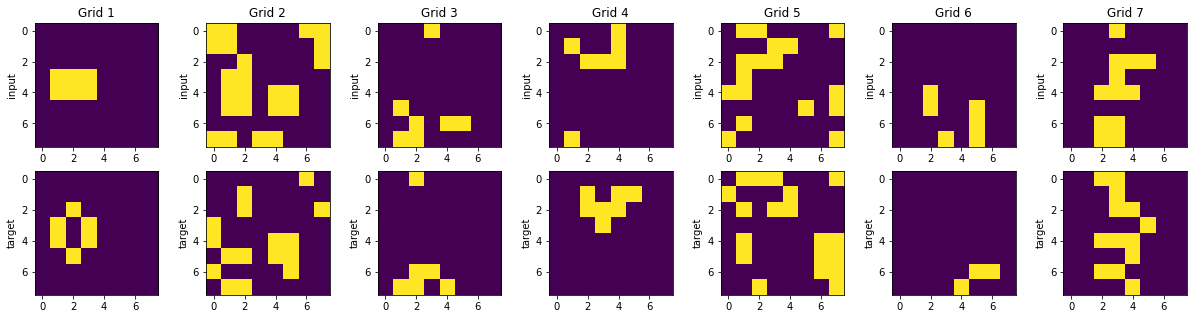

In [116]:
# generating some inputs and targets for the general mode

x, y = generate_input(trials=8, grid_shape=(8,8),steps_before_generating_output=2)


plt.figure(figsize=(3*len(x), 5))
for i in range(len(x)):
    plt.subplot(2, len(x), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(x[i])
    plt.ylabel('input')
    plt.subplot(2, len(x), len(x)+i+1)
    plt.imshow(y[i])
    plt.ylabel('target')    

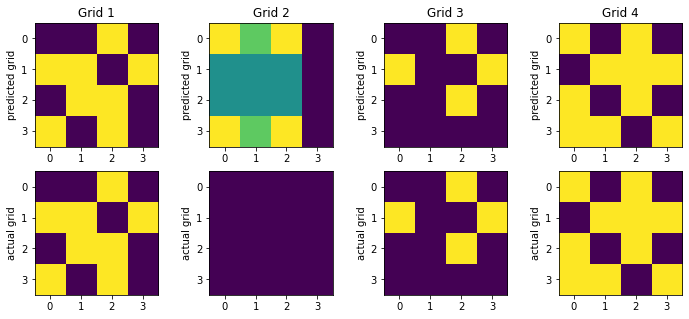

In [115]:
# checking that the general model actually works
y_pred = game(x)

plt.figure(figsize=(3*len(x), 5))
for i in range(len(y)):
    plt.subplot(2, len(y), i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(y_pred[i])
    plt.ylabel('predicted grid')
    plt.subplot(2, len(y), len(y)+i+1)
    plt.imshow(y[i])
    plt.ylabel('actual grid')

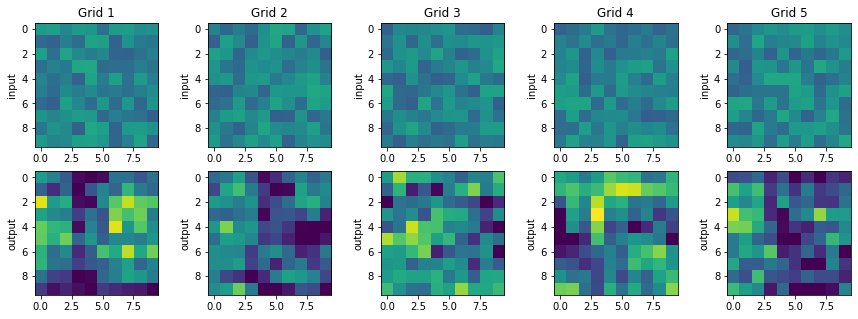

In [9]:
n = len(y)

input_img = tf.Variable(tf.random.uniform(shape=(n,10, 10), minval=0.3, maxval=0.6), name='input_image', trainable=True, validate_shape=True)

output_img = game(input_img)


plt.figure(figsize=(3*n, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.title('Grid ' + str(i+1))
    plt.imshow(input_img[i], vmin=0, vmax=1)
    plt.ylabel('input')
    plt.subplot(2, n, n+i+1)
    plt.imshow(output_img[i], vmin=0, vmax=1)
    plt.ylabel('output')


In [124]:
class ContinuousReverseGame(tf.keras.models.Model):
    
    def __init__(self, min_v, max_v, grid_len):
        super(ContinuousReverseGame, self).__init__()
        self.min_v = min_v
        self.max_v = max_v
        self.l = grid_len
        self.k1 = tf.constant([[1,1,1],[1,0,1],[1,1,1]], dtype='float32')
        self.k1 = tf.reshape(self.k1, shape=(3,3,1,1))
        self.k2 = tf.constant([[0,0,0],[0,1,0],[0,0,0]], dtype='float32')
        self.k2 = tf.reshape(self.k2, shape=(3,3,1,1))
        self.input_img = tf.Variable(tf.random.uniform(shape=(1,self.l+2,self.l+2), minval=self.min_v, maxval=self.max_v), trainable=True, validate_shape=True, constraint=tf.keras.constraints.min_max_norm(0,1))

        

   # def build(self, input_shape):
        
        #self.input_img = self.add_weight(name="W", shape=(1,self.l,self.l), initializer= tf.keras.initializers.RandomUniform(minval=0.3, maxval=0.5), trainable=True)
        
    def call(self, target):
        self.input_img[:,0,:].assign(self.input_img[:,-2,:])
        self.input_img[:,-1,:].assign(self.input_img[:,1,:])
        self.input_img[:,:,0].assign(self.input_img[:,:,-2])
        self.input_img[:,:,-1].assign(self.input_img[:,:,1])

            
        input_img = tf.reshape(self.input_img, shape=(1, self.l+2, self.l+2, 1))
        cell = tf.nn.conv2d(input_img, filters=k2, strides=1, padding='VALID')
        around_cell = tf.nn.conv2d(input_img, filters=k1, strides=1, padding='VALID')

        almost_zero = 0.01
        border = 0.8

        x1 = tf.math.maximum(((8-around_cell)/(8-3))*almost_zero, (3+border-around_cell)/border )
        x2 = tf.math.maximum((around_cell-(3-border))/border, around_cell*almost_zero/3 )

        x3 = tf.math.maximum((cell-(1-border))/border, cell*almost_zero)

        x4 = tf.math.maximum((around_cell-(2-border))/border, around_cell*almost_zero/2 )

        x12 = tf.math.minimum(x1,x2)
        x34 = tf.math.minimum(x3,x4)

        x5 = tf.math.minimum(x1,x34)
        xx = tf.math.maximum(x12,x5)

        xx = tf.reshape(xx, shape=(l,l))
        
        return xx



In [125]:
def loss_function(xx,target):
    xx = tf.reshape(xx, shape=(l,l))
    y = tf.math.abs(xx-target)
    
    loss = tf.reduce_mean(y)

    loss1 =tf.reduce_mean(tf.math.abs(xx - xx**2))
    return loss + loss1



game = ContinuousReverseGame(0.1, 0.3, 8)


In [128]:
y[:1]

<tf.Tensor: id=71591, shape=(1, 8, 8), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)>

In [127]:
game.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

game.fit(y[:1], y[:1], epochs=500)

ValueError: in converted code:

    <ipython-input-124-bdadd5754c73>:47 call  *
        xx = tf.reshape(xx, shape=(l,l))
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\ops\array_ops.py:131 reshape
        result = gen_array_ops.reshape(tensor, shape, name)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\ops\gen_array_ops.py:8116 reshape
        "Reshape", tensor=tensor, shape=shape, name=name)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\op_def_library.py:793 _apply_op_helper
        op_def=op_def)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\func_graph.py:548 create_op
        compute_device)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\ops.py:3429 _create_op_internal
        op_def=op_def)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1773 __init__
        control_input_ops)
    C:\Users\Lisa\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\ops.py:1613 _create_c_op
        raise ValueError(str(e))

    ValueError: Cannot reshape a tensor with 64 elements to shape [4,4] (16 elements) for 'continuous_reverse_game_9/Reshape_1' (op: 'Reshape') with input shapes: [1,8,8,1], [2] and with input tensors computed as partial shapes: input[1] = [4,4].


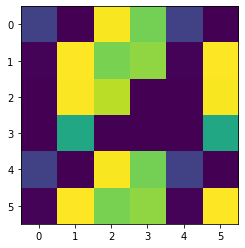

In [110]:
f = game.get_weights()[0][0]

a = (f > 0.55)*1.
plt.imshow(f, vmin=0, vmax=1 )


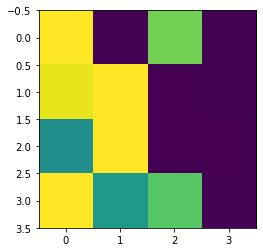

In [111]:
plt.imshow(game(f), vmin=0, vmax=1 )


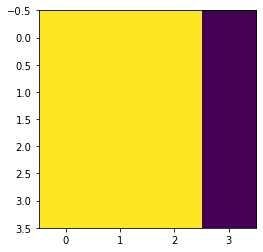

In [87]:
plt.imshow(y[0], vmin=0, vmax=1 )
